#频繁模式与关联规则挖掘#
数据集：Wine Reviews

##导入并展示数据##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools
import csv 
#encoding:utf-8

In [2]:
#导入数据
data = pd.read_csv('wine-reviews/winemag-data_first150k.csv')
print('数据行数:'+str(data.shape[0]))
print('数据列数:'+str(data.shape[1]))
print("每个变量数据类型:")
print(data.dtypes)
print("数据前五行:")
data.head()

数据行数:150930
数据列数:11
每个变量数据类型:
Unnamed: 0       int64
country         object
description     object
designation     object
points           int64
price          float64
province        object
region_1        object
region_2        object
variety         object
winery          object
dtype: object
数据前五行:


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


##1、对数据集进行处理，转换成适合进行关联规则挖掘的形式##
对于标称属性，可直接加入事务集
对于数值属性，需要先将其离散化：
对于属性points：其取值区间在[80，100]，将其划分为四段：95-100、90-95、85-90、80_85
对于属性price：其取值区间在[4，2300],因为大多数值都在0-100中间，所以划分为四段：0-10，10-50,50-100,100以上

In [3]:
trans = []
features = ['country','designation','points','price','winery','variety']
for i, r in data.iterrows():
    tmp = []
    for fea in features:
        if not pd.isna(r[fea]):
            if fea == 'points':
                value = 0
                if r[fea] >= 95:
                    value = '95_100'
                elif r[fea] >= 90:
                    value = '90_95'
                elif r[fea] >= 85:
                    value = '85_90'
                else:
                    value = '80_85'
                tmp.append(value)
            elif fea == 'price':
                value = 0
                if r[fea] <= 10:
                    value = '0_10'
                elif r[fea] <= 50:
                    value = '10_50'
                elif r[fea] <= 100 :
                    value = '50_100'
                else:
                    value = '100'
                tmp.append(value)
            else:
                tmp.append(r[fea])
    tmp = tuple(tmp)
    trans.append(tmp)
print(trans[0:5])

[('US', "Martha's Vineyard", '95_100', '100', 'Heitz', 'Cabernet Sauvignon'), ('Spain', 'Carodorum Selección Especial Reserva', '95_100', '100', 'Bodega Carmen Rodríguez', 'Tinta de Toro'), ('US', 'Special Selected Late Harvest', '95_100', '50_100', 'Macauley', 'Sauvignon Blanc'), ('US', 'Reserve', '95_100', '50_100', 'Ponzi', 'Pinot Noir'), ('France', 'La Brûlade', '95_100', '50_100', 'Domaine de la Bégude', 'Provence red blend')]


In [25]:
##Apriori算法
def apriori(transactions, support=0.1, confidence=0.8, lift=1, minlen=2, maxlen=2,show=0):
    item_2_tranidxs = defaultdict(list)
    itemset_2_tranidxs = defaultdict(list)

    for tranidx, tran in enumerate(transactions):
        for item in tran:
            item_2_tranidxs[item].append(tranidx)
            itemset_2_tranidxs[frozenset([item])].append(tranidx)

    item_2_tranidxs = dict([(k, frozenset(v)) for k, v in item_2_tranidxs.items()])
    itemset_2_tranidxs = dict([
        (k, frozenset(v)) for k, v in itemset_2_tranidxs.items()])

    tran_count = float(len(transactions))
    # print('Extracting rules in {} transactions...'.format(int(tran_count)))

    valid_items = set(item
        for item, tranidxs in item_2_tranidxs.items()
            if (len(tranidxs) / tran_count >= support))

    pivot_itemsets = [frozenset([item]) for item in valid_items]
    freqsets = []

    if minlen == 1:
        freqsets.extend(pivot_itemsets)

    for i in range(maxlen - 1):
        new_itemset_size = i + 2
        new_itemsets = []

        for pivot_itemset in pivot_itemsets:
            pivot_tranidxs = itemset_2_tranidxs[pivot_itemset]
            for item, tranidxs in item_2_tranidxs.items():
                if item not in pivot_itemset:
                    common_tranidxs = pivot_tranidxs & tranidxs
                    if len(common_tranidxs) / tran_count >= support:
                        new_itemset = frozenset(pivot_itemset | set([item]))
                        if new_itemset not in itemset_2_tranidxs:
                            new_itemsets.append(new_itemset)
                            itemset_2_tranidxs[new_itemset] = common_tranidxs

        if new_itemset_size > minlen - 1:
            freqsets.extend(new_itemsets)

        pivot_itemsets = new_itemsets

    if show == 1:
        print('{} frequent patterns found'.format(len(freqsets)))
        for item in freqsets:
            print(item)

    for freqset in freqsets:
        for item in freqset:
            rhs = frozenset([item])
            lhs = freqset - rhs
            support_rhs = len(itemset_2_tranidxs[rhs]) / tran_count
            if len(lhs) == 0:
                lift_rhs = float(1)
                if support_rhs >= support and support_rhs > confidence and lift_rhs > lift:
                    yield (lhs, rhs, support_rhs, support_rhs, lift_rhs)
            else:
                confidence_lhs_rhs = len(itemset_2_tranidxs[freqset]) \
                    / float(len(itemset_2_tranidxs[lhs]))
                lift_lhs_rhs = confidence_lhs_rhs / support_rhs

                if confidence_lhs_rhs >= confidence and lift_lhs_rhs > lift:
                    support_lhs_rhs = len(itemset_2_tranidxs[freqset]) / tran_count
                    yield (lhs, rhs, support_lhs_rhs, confidence_lhs_rhs, lift_lhs_rhs)

##2、找出频繁模式##
采用Apriori算法，设定支持度阈值为0.01，置信度阈值为0.8，lift阈值为1，获取频繁项集和关联规则

In [27]:
rules = apriori(trans, support=0.01, confidence=0.8, lift=1,show=1)
rules_sorted = sorted(rules, key=lambda x: (x[3], x[2], x[1]), reverse=True) 

108 frequent patterns found
frozenset({'100', '90_95'})
frozenset({'10_50', 'Argentina'})
frozenset({'Argentina', 'Malbec'})
frozenset({'85_90', 'Argentina'})
frozenset({'Argentina', '80_85'})
frozenset({'10_50', 'South Africa'})
frozenset({'85_90', 'South Africa'})
frozenset({'Italy', 'Nebbiolo'})
frozenset({'50_100', 'France'})
frozenset({'France', 'Pinot Noir'})
frozenset({'10_50', 'France'})
frozenset({'Chardonnay', 'France'})
frozenset({'90_95', 'France'})
frozenset({'85_90', 'France'})
frozenset({'Bordeaux-style Red Blend', 'France'})
frozenset({'80_85', 'France'})
frozenset({'US', '90_95'})
frozenset({'Cabernet Sauvignon', '90_95'})
frozenset({'50_100', '90_95'})
frozenset({'90_95', 'Pinot Noir'})
frozenset({'90_95', 'Italy'})
frozenset({'10_50', '90_95'})
frozenset({'Chardonnay', '90_95'})
frozenset({'Syrah', '90_95'})
frozenset({'Red Blend', '90_95'})
frozenset({'Riesling', '90_95'})
frozenset({'Portugal', '90_95'})
frozenset({'Bordeaux-style Red Blend', '90_95'})
frozenset({'

##3、导出关联规则，计算其支持度和置信度##

In [28]:
with open('rules.csv', 'w') as f:
    f_csv = csv.writer(f, delimiter=',')
    f_csv.writerow(['Rule','Support','Confidence'])
    for r in rules_sorted:
        f_csv.writerow([f'{str(list(r[0])[0])} -> {str(list(r[1])[0])}', r[2], r[3]])
pd.read_csv(r'rules.csv', encoding='ISO-8859-1')

,Rule,Support,Confidence
0,Portuguese Red -> Portugal,0.014682,1.000000
1,"Corvina, Rondinella, Molinara -> Italy",0.011144,1.000000
2,Zinfandel -> US,0.025164,0.997374
3,Nebbiolo -> Italy,0.014510,0.977242
4,Zinfandel -> 10_50,0.023541,0.933036
5,New Zealand -> 10_50,0.018823,0.855723
6,Germany -> Riesling,0.013874,0.853997
7,Tempranillo -> Spain,0.014225,0.837690
8,Sauvignon Blanc -> 10_50,0.034996,0.835495
9,US -> 10_50,0.337766,0.817010


##4、使用Lift、Kulc对规则进行评价##

In [29]:
kulc = []
for r1 in rules_sorted:
    conf1 = r1[3]
    conf2 = 0
    for r2 in rules_sorted:
        if r2[0] == r1[1] and r2[1] == r1[0]:
            conf2 = r2[3]
    k = (conf1 + conf2) / 2
    kulc.append(k)
with open('evaluation.csv', 'w') as f:
    f_csv = csv.writer(f, delimiter=',')
    f_csv.writerow(['Rule','Support','Confidence','Lift','Kulc'])
    index = 0
    for r in rules_sorted:
        f_csv.writerow([f'{str(list(r[0])[0])} -> {str(list(r[1])[0])}', r[2], r[3],r[4],kulc[index]])
        index+=1
pd.read_csv('evaluation.csv', encoding='ISO-8859-1')

,Rule,Support,Confidence,Lift,Kulc
0,Portuguese Red -> Portugal,0.014682,1.000000,28.359639,0.500000
1,"Corvina, Rondinella, Molinara -> Italy",0.011144,1.000000,6.428571,0.500000
2,Zinfandel -> US,0.025164,0.997374,2.412514,0.498687
3,Nebbiolo -> Italy,0.014510,0.977242,6.282272,0.488621
4,Zinfandel -> 10_50,0.023541,0.933036,1.311165,0.466518
5,New Zealand -> 10_50,0.018823,0.855723,1.202520,0.427861
6,Germany -> Riesling,0.013874,0.853997,23.329181,0.426998
7,Tempranillo -> Spain,0.014225,0.837690,15.291798,0.418845
8,Sauvignon Blanc -> 10_50,0.034996,0.835495,1.174095,0.417748
9,US -> 10_50,0.337766,0.817010,1.148119,0.408505


##5、对挖掘结果进行分析##
设定支持度阈值为0.01，置信度阈值为0.8，lift阈值为1，利用Apriori算法可以得到108个频繁项集和12个关联规则。
首先分析第0条关联规则：Portuguese Red -> Portugal
Portuguese Red是红酒的种类（variety）， Portugal是红酒生产的国家，这条关联规则的置信度为1，可以说明所有Portuguese Red的红酒都是Portugal生产的。
第1、2、3条关联规则同理，第6条关联规则Germany -> Riesling说明德国生产的大多数红酒种类都是Riesling。

第4条关联规则：Zinfandel -> 10_50 说明Zinfandel这个种类的红酒价格基本都在10-50元；
第5条关联规则：New Zealand -> 10_50说明新西兰生产的大多数红酒价格都很便宜在，10到50元之间

可以看出，0、1、2、3、6、7、10这几条关联规则基本上都是表明了红酒产地与其种类之间的关系；
4、8、11、12这四条关联规则表明了红酒种类与其价格的关系；
5和9这两条关联规则表明了红酒产地与其价格的关系。

##6、可视化展示##
设置支持度阈值为0.001，置信度阈值为0.5，lift阈值为0.1，可得到585条频繁项集、286条关联规则，对其绘制散点图。

In [35]:
rules = apriori(trans, support=0.001, confidence=0.5, lift=0.1)
sup = []
conf = []
for r in rules:
    sup.append(r[2])
    conf.append(r[3])

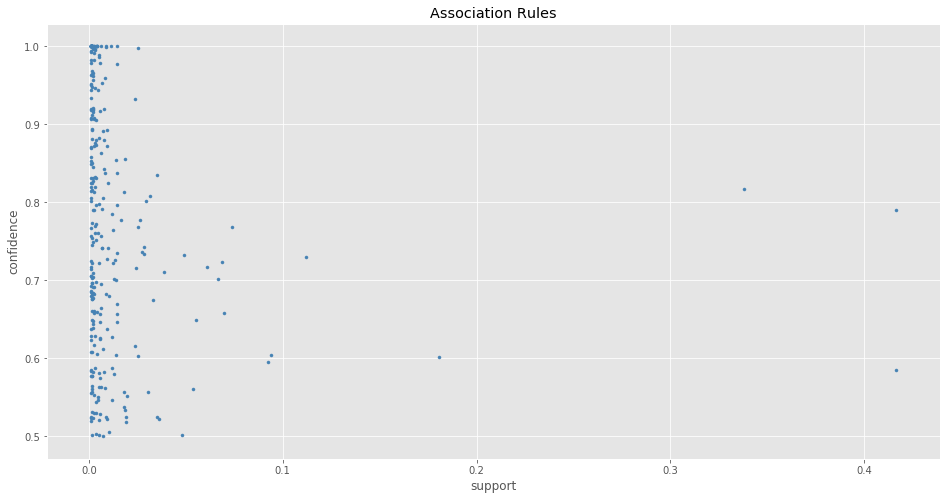

In [36]:
plt.figure(figsize=(16,8))
plt.style.use('ggplot')
plt.title('Association Rules')
plt.ylabel('confidence')
plt.xlabel('support')
w = range(1,10,1)
x=[0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]
plt.scatter(sup, conf, marker='.',color = 'steelblue')
#plt.xticks(w,x)

分析：从散点图中可以看出，大部分关联规则分布在支持度0.01到0.1之间，置信度分别相对均匀，位于0.7以上的关联规则较多。